### Strava Activity Data Analisys

Overview:

Strava is a popular social network for athletes, specifically designed to record and share activities in sports such as running, cycling, swimming, and more. Utilizing data from smart devices, Strava logs various metrics including duration, distance covered during the activity, date, geographical data, type of sport, heart rate and etc. Users can also interact socially by giving "kudos," similar to likes on Facebook.
As an avid user of Strava with a keen interest in its application, I have decided to delve deeper into the data available on this platform. Although my personal dataset is limited, a friend has provided access to their extensive historical data, which offers a richer foundation for analysis.

Objective:

The objective of this project is to investigate athlete performance by employing clustering algorithms to identify patterns and group workout routines. This will enable a deeper understanding of training effectiveness and facilitate personalized training plans for athletes.

Methodology:

1. Data collection using Strava api
2. Features selecton: identify key performance indicators for clustering analysis
3. Data preproccesing: clean, formatting and scale data
4. Implement multiple clustering techniques
5. Evaluate the performance of each algorithm
6. Hyperparameter Tuning
7. Analyze the resulting clusters to identify common traits and performance patterns
8. Draw Conclusions by summarizing the findings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

### Connect to Strava API to get data

In [2]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

client_id = '127283'
client_secret = 'bf5f4e8174957089dafe2ec5d30f60a1f918b7e2'
refresh_token = '935d5e602e34ce66ca630c667d4ff8d1f07d2d3d'
auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': client_id,
    'client_secret': client_secret,
    'refresh_token': refresh_token,
    'grant_type': 'refresh_token'
}

res = requests.post(auth_url, data=payload, verify=False)
response_json = res.json()
access_token = response_json['access_token']

def fetch_activities(access_token, per_page=200):
    header = {'Authorization': 'Bearer ' + access_token}
    page = 1
    activities = []
    while True:
        param = {'per_page': per_page, 'page': page}
        response = requests.get(activities_url, headers=header, params=param).json()
        if not response:
            break
        activities.extend(response)
        page += 1
    return activities

all_activities = fetch_activities(access_token)

df = pd.DataFrame(all_activities)

df.to_csv('strava_activities.csv', index=False)

### Display data

In [3]:
pd.set_option('display.max_columns', None)
runs = df[df['sport_type'] == 'Run']
runs.head()

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,start_date,start_date_local,timezone,utc_offset,location_city,location_state,location_country,achievement_count,kudos_count,comment_count,athlete_count,photo_count,map,trainer,commute,manual,private,visibility,flagged,gear_id,start_latlng,end_latlng,average_speed,max_speed,has_heartrate,heartrate_opt_out,display_hide_heartrate_option,elev_high,elev_low,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,average_watts,kilojoules,device_watts,average_temp,average_cadence,max_watts,weighted_average_watts,average_heartrate,max_heartrate
0,2,"{'id': 11679027, 'resource_state': 1}",Пятница. Завтра велик!,10090.4,3645,3657,137.6,Run,Run,0.0,11538057735,2024-05-31T05:59:41Z,2024-05-31T08:59:41Z,(GMT+03:00) Europe/Moscow,10800.0,None,None,Madagascar,0,302,0,1,0,"{'id': 'a11538057735', 'summary_polyline': '',...",False,False,False,False,everyone,False,g8179694,[],[],2.768,3.878,False,False,False,204.8,180.2,1.231612e+10,12316123755,stripped_7230569B-135B-46C9-A2B3-A74155968EF0.fit,False,0,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"{'id': 11679027, 'resource_state': 1}",Перед сном,5015.9,1758,2483,53.8,Run,Run,0.0,11534227989,2024-05-30T16:28:01Z,2024-05-30T19:28:01Z,(GMT+03:00) Europe/Moscow,10800.0,None,None,Madagascar,0,274,1,1,0,"{'id': 'a11534227989', 'summary_polyline': '',...",False,False,False,False,everyone,False,g8179694,[],[],2.853,5.026,False,False,False,203.0,182.4,1.231219e+10,12312186011,stripped_31797837-2921-4BC4-A77A-1214BDB72D2E.fit,False,0,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"{'id': 11679027, 'resource_state': 1}",Ромашке,10270.1,3668,3696,112.2,Run,Run,0.0,11514207280,2024-05-28T04:37:41Z,2024-05-28T07:37:41Z,(GMT+03:00) Europe/Moscow,10800.0,None,None,Madagascar,0,310,1,1,0,"{'id': 'a11514207280', 'summary_polyline': '',...",False,False,False,False,everyone,False,g8179694,[],[],2.800,4.128,False,False,False,204.0,183.2,1.229156e+10,12291558362,stripped_B43E0FC8-83AB-43BD-B659-503DEA68E3DF.fit,False,0,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,"{'id': 11679027, 'resource_state': 1}",Опять трасса и грузовики,8950.1,3272,3272,51.3,Run,Run,0.0,11508559168,2024-05-27T06:40:04Z,2024-05-27T09:40:04Z,(GMT+03:00) Europe/Moscow,10800.0,None,None,Madagascar,0,305,0,1,0,"{'id': 'a11508559168', 'summary_polyline': 'oy...",False,False,False,False,everyone,False,g8179694,"[55.811296, 37.129746]","[55.811779, 37.130635]",2.735,4.022,False,False,False,199.1,171.3,1.228576e+10,12285759492,stripped_11508530523-2.gpx,False,0,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,"{'id': 11679027, 'resource_state': 1}",По песку. Вместо обеда,6276.3,2286,3529,17.8,Run,Run,0.0,11492576685,2024-05-25T08:44:56Z,2024-05-25T12:44:56Z,(GMT+04:00) Asia/Dubai,14400.0,None,None,Madagascar,0,312,0,1,0,"{'id': 'a11492576685', 'summary_polyline': 'en...",False,False,False,False,everyone,False,g12061999,"[25.17400120384991, 55.21846172399819]","[25.17629725858569, 55.21781765855849]",2.746,6.201,False,False,False,6.8,-2.0,1.226922e+10,12269217685,stripped_E5D4E9A4-2888-4AF5-977C-B15DED5BAB30.fit,False,0,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For my project, I will focus exclusively on evaluating running training sessions, as they have the most entries. I will retain the most important and clear metrics, such as distance, duration, and elevation. Elevation is particularly relevant for mountainous or hilly runs, as these runs may be slower but more intense.

Variables explained:

The activity's distance, in meters

The activity's moving time, in seconds

The activity's total elevation gain

In [4]:
columns_to_keep = ['distance', 'moving_time', 'total_elevation_gain']
runs = runs[columns_to_keep]
runs.head()

,distance,moving_time,total_elevation_gain
0,10090.4,3645,137.6
1,5015.9,1758,53.8
2,10270.1,3668,112.2
3,8950.1,3272,51.3
4,6276.3,2286,17.8


### Exploratory Data Analysis

In [5]:
runs.isnull().sum()
#no missing value

distance                0
moving_time             0
total_elevation_gain    0
dtype: int64

In [6]:
runs.info()
#confirm correct formats

<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, 0 to 2084
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              1295 non-null   float64
 1   moving_time           1295 non-null   int64  
 2   total_elevation_gain  1295 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 40.5 KB


In [7]:
runs.describe()
#statistic

,distance,moving_time,total_elevation_gain
count,1295.000000,1295.000000,1295.000000
mean,10002.157606,3505.364479,65.040077
std,6905.908581,2569.671664,125.358984
min,0.000000,14.000000,0.000000
25%,6185.550000,2193.000000,22.550000
50%,10060.300000,3416.000000,38.000000
75%,11332.600000,3976.000000,67.000000
max,117681.000000,39718.000000,1700.100000


During my experiments with models, I realized how sensitive clustering algorithms can be to outliers. Identifying outliers in data is a challenging task, often requiring more than just primitive calculations; it demands domain knowledge as well. For instance, I know that my friend doesn’t typically engage in runs as long as 40k. The entries in the dataset representing such long runs are likely from running competitions and not part of his usual training routine. Therefore, I decided to filter the dataframe to include only those runs with a distance of less than 40k.

Another important decision I had to make was regarding the elevation gain. The dataset includes some runs with very high elevation gain, although there aren’t many of them. Despite this, I decided to retain these entries, knowing that my friend does occasional hiking. This aspect is an important part of his training program, and thus, these data points are relevant for a comprehensive analysis.

In [8]:
running_perfomance = runs[runs['distance'] < 40000]

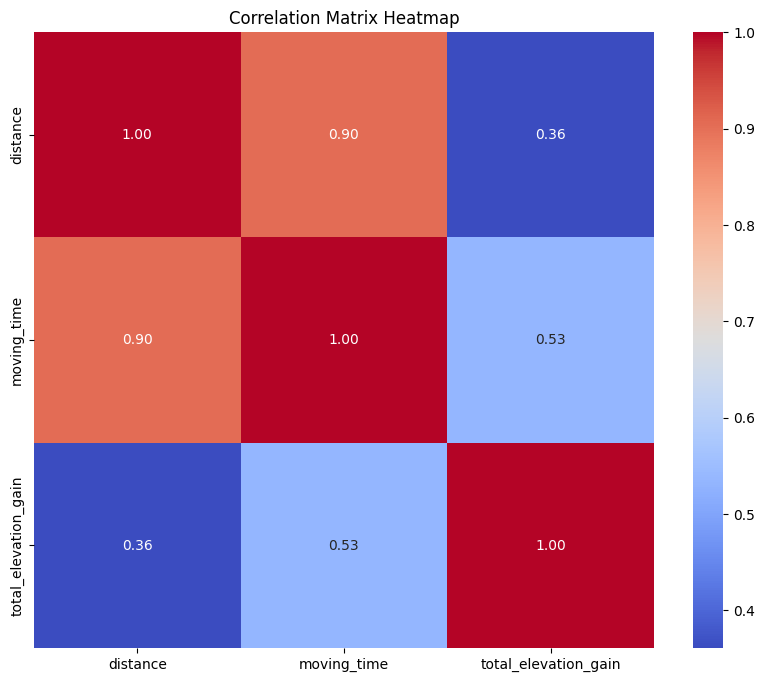

In [9]:
correlation_matrix = running_perfomance.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Rescaling metrics

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(running_perfomance)
scaled_data

array([[ 0.0918089 ,  0.12992794,  0.64796535],
       [-0.95092243, -0.81393264, -0.07630052],
       [ 0.12873447,  0.14143234,  0.42843846],
       ...,
       [-1.19894227, -0.85444812, -0.33212713],
       [-1.22906631, -0.88245882, -0.33039857],
       [-1.31276016, -1.02251232, -0.33126285]])

### Building models

### K-Means Clustering

The elbow method is a technique used to determine the optimal number of clusters in a K-means clustering algorithm.
The idea is to plot the cost (or inertia) of the algorithm for different values of ‘k’ (number of clusters) and look for an “elbow” point on the graph.

In [11]:
inertia_list = []
range_n_clusters = [1, 2, 3, 4, 5, 6]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(scaled_data)

    inertia_list.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

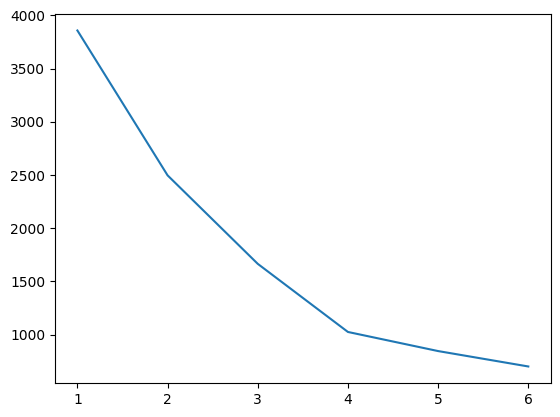

In [12]:
plt.plot(range_n_clusters, inertia_list)

### Silhouette Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


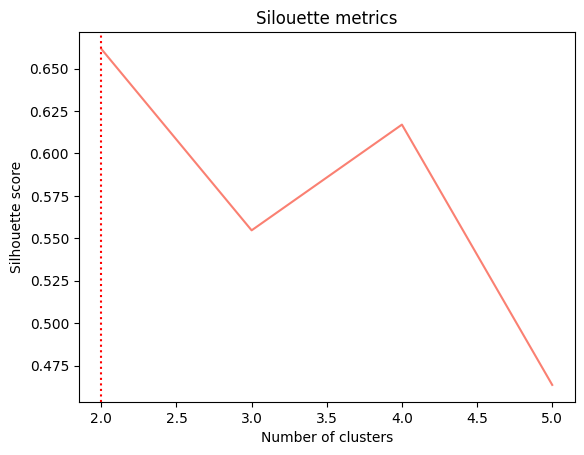

In [13]:
sil_scores = list()
for i in range(2, 6):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(scaled_data)
    sil_scores.append(silhouette_score(running_perfomance, kmeans.labels_))

plt.plot(range(2, 6), sil_scores, color = 'salmon')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silouette metrics')
plt.axvline(x = sil_scores.index(max(sil_scores))+2, linestyle = 'dotted', color = 'red')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [15]:
kmeans.labels_

array([0, 3, 0, ..., 3, 3, 3], dtype=int32)

In [16]:
running_perfomance["Cluster_label_kmeans"] = kmeans.labels_
running_perfomance.head()

<ipython-input-16-50ced1597df8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_perfomance["Cluster_label_kmeans"] = kmeans.labels_


,distance,moving_time,total_elevation_gain,Cluster_label_kmeans
0,10090.4,3645,137.6,0
1,5015.9,1758,53.8,3
2,10270.1,3668,112.2,0
3,8950.1,3272,51.3,0
4,6276.3,2286,17.8,3


In [17]:
kmeans_count = running_perfomance['Cluster_label_kmeans'].value_counts()

kmeans_percentages = (kmeans_count / len(running_perfomance)) * 100

print(kmeans_percentages)

Cluster_label_kmeans
0    59.486781
3    34.136858
2     5.832037
1     0.544323
Name: count, dtype: float64


<Axes: xlabel='Cluster_label_kmeans', ylabel='distance'>

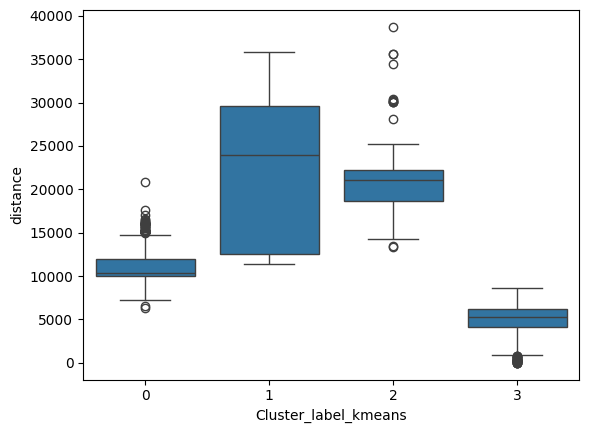

In [18]:
sns.boxplot(x="Cluster_label_kmeans", y="distance", data=running_perfomance)

<Axes: xlabel='Cluster_label_kmeans', ylabel='moving_time'>

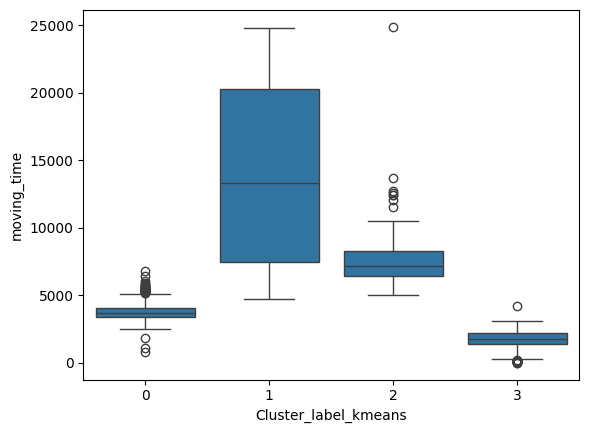

In [19]:
sns.boxplot(x="Cluster_label_kmeans", y="moving_time", data=running_perfomance)

<Axes: xlabel='Cluster_label_kmeans', ylabel='total_elevation_gain'>

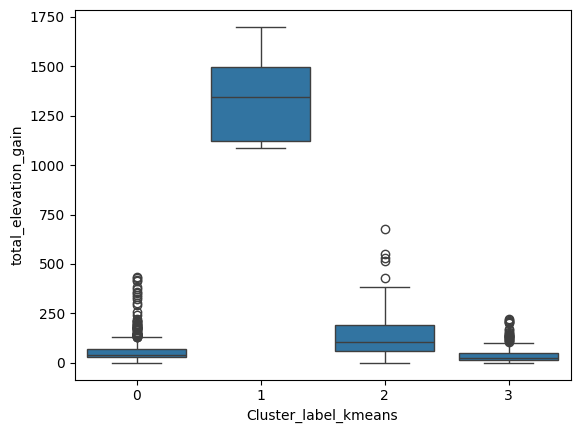

In [20]:
sns.boxplot(x="Cluster_label_kmeans", y="total_elevation_gain", data=running_perfomance)

In [21]:
kmeans_summary = running_perfomance.groupby('Cluster_label_kmeans').agg({
    'distance': ['mean', 'median', 'std'],
    'moving_time': ['mean', 'median', 'std'],
    'total_elevation_gain': ['mean', 'median', 'std']
})

kmeans_summary

distance                          moving_time  \
                              mean   median           std          mean   
Cluster_label_kmeans                                                      
0                     11028.656078  10385.5   1792.517400   3794.704575   
1                     22204.557143  23912.9  10500.556513  14036.714286   
2                     21915.453333  21117.2   5084.523117   7909.386667   
3                      4933.181777   5253.4   2038.322642   1728.958998   

                                           total_elevation_gain          \
                       median          std                 mean  median   
Cluster_label_kmeans                                                      
0                      3672.0   662.917441            57.720261    41.0   
1                     13313.0  7934.140905          1339.714286  1346.1   
2                      7180.0  2759.178721           150.382667   106.2   
3                      1801.0   678.145169            35.825057    25.5   

                                  
                             std  
Cluster_label_kmeans              
0                      57.719709  
1                     237.669178  
2                     136.387204  
3                      37.843409

	•	Cluster 0: Moderate distance, moderate speed, flat
	•	Cluster 1: Short and fast and flat
	•	Cluster 2: Long and moderate pace runs
	•	Cluster 3: Long runs in mountains

### Hierarchical Clustering

In [22]:
mergings = linkage(scaled_data, method="complete", metric="euclidean")

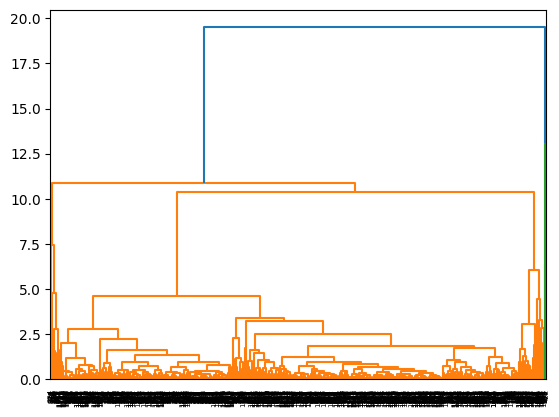

In [23]:
dendrogram(mergings)
plt.show()

In [24]:
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(
    -1,
)
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
running_perfomance["Cluster_label_hier"] = cluster_labels
running_perfomance.head()

<ipython-input-25-c0145c8f18b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_perfomance["Cluster_label_hier"] = cluster_labels


,distance,moving_time,total_elevation_gain,Cluster_label_kmeans,Cluster_label_hier
0,10090.4,3645,137.6,0,0
1,5015.9,1758,53.8,3,0
2,10270.1,3668,112.2,0,0
3,8950.1,3272,51.3,0,0
4,6276.3,2286,17.8,3,0


<Axes: xlabel='Cluster_label_hier', ylabel='distance'>

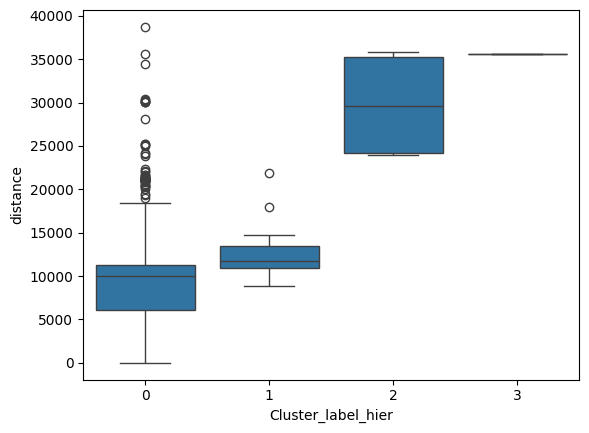

In [26]:
sns.boxplot(x="Cluster_label_hier", y="distance", data=running_perfomance)

<Axes: xlabel='Cluster_label_hier', ylabel='moving_time'>

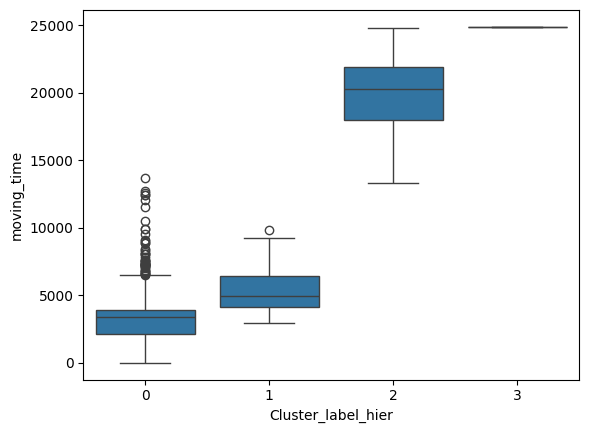

In [27]:
sns.boxplot(x="Cluster_label_hier", y="moving_time", data=running_perfomance)

<Axes: xlabel='Cluster_label_hier', ylabel='total_elevation_gain'>

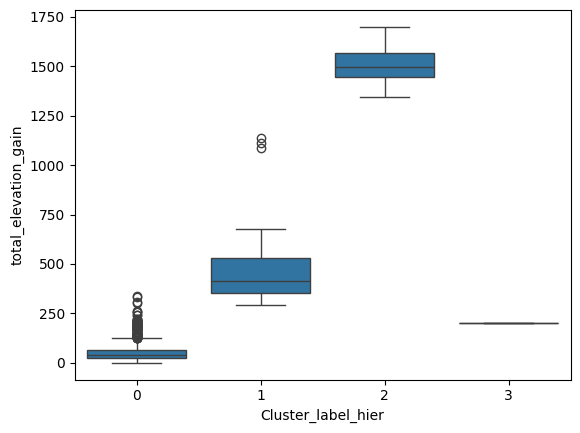

In [28]:
sns.boxplot(x="Cluster_label_hier", y="total_elevation_gain", data=running_perfomance)

In [29]:
# Calculate summary statistics for hierarchical clusters
hierarchical_summary = running_perfomance.groupby('Cluster_label_hier').agg({
    'distance': ['mean', 'median', 'std'],
    'moving_time': ['mean', 'median', 'std'],
    'total_elevation_gain': ['mean', 'median', 'std']
})

hierarchical_summary

distance                          moving_time  \
                            mean    median          std          mean   
Cluster_label_hier                                                      
0                    9506.338840  10049.70  4687.202288   3281.463860   
1                   12662.809091  11775.40  2866.204422   5390.954545   
2                   29742.925000  29593.45  6577.316822  19644.250000   
3                   35645.500000  35645.50          NaN  24882.000000   

                                         total_elevation_gain           \
                     median          std                 mean   median   
Cluster_label_hier                                                       
0                    3379.0  1639.497668             50.13471    37.00   
1                    4920.0  1812.762493            507.90000   416.20   
2                   20247.0  4761.761045           1510.87500  1498.65   
3                   24882.0          NaN            203.00000   203.00   

                                
                           std  
Cluster_label_hier              
0                    46.729217  
1                   261.596141  
2                   146.269851  
3                          NaN

In [30]:
hier_count = running_perfomance['Cluster_label_hier'].value_counts()

hier_percentages = (hier_count / len(running_perfomance)) * 100

print(hier_percentages)

Cluster_label_hier
0    97.900467
1     1.710731
2     0.311042
3     0.077760
Name: count, dtype: float64


	•	Cluster 0: Around 10k runs, moderate moving time.
	•	Cluster 1: Longer in distance and time, hilly runs
	•	Cluster 2: Long distance, mountains runs
	•	Cluster 3: Few very long-distance runs

### Gaussian Mixture Models

In [31]:
gmm = GaussianMixture(n_components=4)
gmm.fit(scaled_data)

labels = gmm.predict(scaled_data)

In [32]:
running_perfomance["Cluster_label_gmm"] = labels

<ipython-input-32-86b7d6d7cc2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_perfomance["Cluster_label_gmm"] = labels


In [33]:
gmm = running_perfomance.groupby('Cluster_label_gmm').agg({
    'distance': ['mean', 'median', 'std'],
    'moving_time': ['mean', 'median', 'std'],
    'total_elevation_gain': ['mean', 'median', 'std']
})

gmm.head()

distance                           moving_time  \
                           mean    median           std          mean   
Cluster_label_gmm                                                       
0                  14605.831148  13525.30   7807.509440   5281.846995   
1                  10738.480587  10309.15   1854.592387   3711.187151   
2                  22204.557143  23912.90  10500.556513  14036.714286   
3                   4959.548684   5231.80   1946.123084   1661.521053   

                                        total_elevation_gain           \
                    median          std                 mean   median   
Cluster_label_gmm                                                       
0                   5033.0  3047.396799           156.771585   140.00   
1                   3641.0   612.297397            43.877514    37.50   
2                  13313.0  7934.140905          1339.714286  1346.10   
3                   1758.5   621.861808            29.095789    24.25   

                               
                          std  
Cluster_label_gmm              
0                  114.680559  
1                   27.764088  
2                  237.669178  
3                   23.805129

In [34]:
gmm_count = running_perfomance['Cluster_label_gmm'].value_counts()

gmm_percentages = (gmm_count / len(running_perfomance)) * 100

print(gmm_percentages)

Cluster_label_gmm
1    55.676516
3    29.548989
0    14.230171
2     0.544323
Name: count, dtype: float64


	•	Cluster 0: Represents moderate-distance activities, flat
	•	Cluster 1: Represents medium to long-distance activities with higher elevation gain. This cluster has a high variation in both distance and elevation gain.
	•	Cluster 2: Short and fast, flat run.
	•	Cluster 3: Long, mountains runs.

### DBSCAN

In [35]:
clustering = DBSCAN(eps=1, min_samples=2).fit(scaled_data)
running_perfomance["Cluster_label_dbscan"] = clustering.labels_

<ipython-input-35-a879147c124e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_perfomance["Cluster_label_dbscan"] = clustering.labels_


In [36]:
dbscan_summary = running_perfomance.groupby('Cluster_label_dbscan').agg({
    'distance': ['mean', 'median', 'std'],
    'moving_time': ['mean', 'median', 'std'],
    'total_elevation_gain': ['mean', 'median', 'std']
})

dbscan_summary.head()

distance                          moving_time  \
                              mean    median          std          mean   
Cluster_label_dbscan                                                      
-1                    26705.375000  24687.30  8358.625150  16898.125000   
 0                     9532.571708  10055.45  4653.334485   3298.117555   
 1                    12237.550000  12237.55  1165.806950   4920.000000   

                                           total_elevation_gain          \
                       median          std                 mean  median   
Cluster_label_dbscan                                                      
-1                    16437.5  6416.261627          1005.525000  1215.9   
 0                     3386.5  1627.375992            55.052429    37.0   
 1                     4920.0   247.487373          1124.400000  1124.4   

                                  
                             std  
Cluster_label_dbscan              
-1                    631.020370  
 0                     62.547410  
 1                     17.536248

In [37]:
dbscan_count = running_perfomance['Cluster_label_dbscan'].value_counts()

dbscan_percentages = (dbscan_count / len(running_perfomance)) * 100

print(dbscan_percentages)

Cluster_label_dbscan
 0    99.222395
-1     0.622084
 1     0.155521
Name: count, dtype: float64


	•	Cluster -1 (Noise): Represents outliers or noise in the dataset. These activities have very high distances and moving times, with a significant total elevation gain. The high standard deviations indicate a wide range of values, showing that this cluster captures varied outlier activities.
	•	Cluster 0: Represents moderate-distance activities with low to moderate elevation gain and moderate moving time. The standard deviations indicate some variability, but activities are relatively consistent.
	•	Cluster 1: Represents longer activities with high elevation gain and longer moving time. The lower standard deviations suggest that these activities are relatively uniform.

### Models comparison

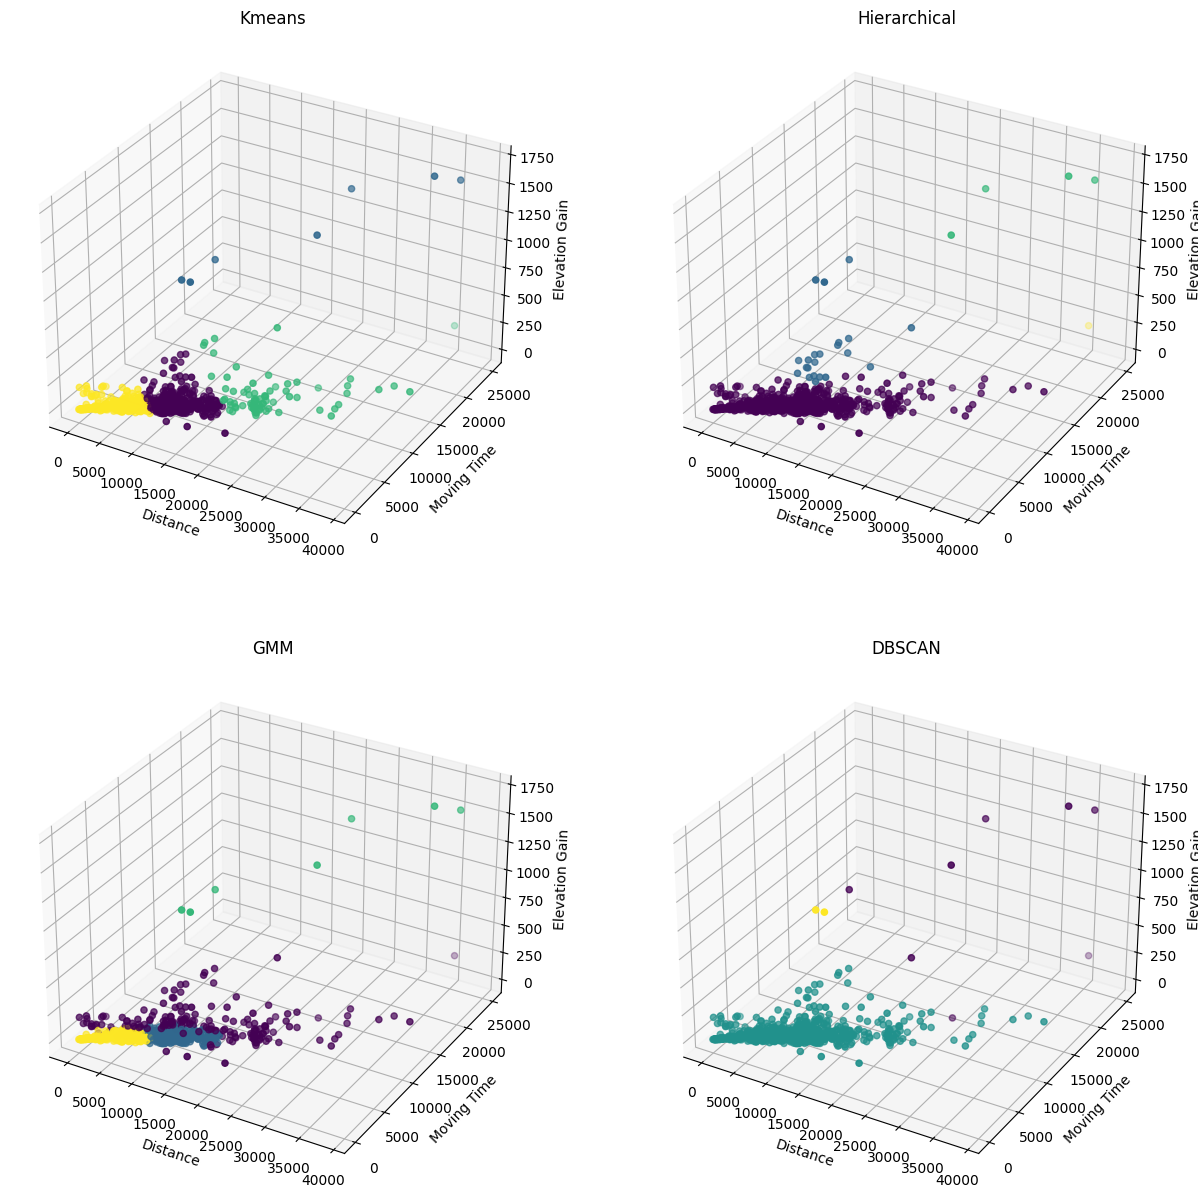

In [38]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

sc1 = ax1.scatter(running_perfomance["distance"], running_perfomance["moving_time"], running_perfomance["total_elevation_gain"], c=running_perfomance["Cluster_label_kmeans"])
sc2 = ax2.scatter(running_perfomance["distance"], running_perfomance["moving_time"], running_perfomance["total_elevation_gain"], c=running_perfomance["Cluster_label_hier"])
sc3 = ax3.scatter(running_perfomance["distance"], running_perfomance["moving_time"], running_perfomance["total_elevation_gain"], c=running_perfomance["Cluster_label_gmm"])
sc4 = ax4.scatter(running_perfomance["distance"], running_perfomance["moving_time"], running_perfomance["total_elevation_gain"], c=running_perfomance["Cluster_label_dbscan"])

ax1.title.set_text("Kmeans")
ax2.title.set_text("Hierarchical")
ax3.title.set_text("GMM")
ax4.title.set_text("DBSCAN")

ax1.set_xlabel('Distance')
ax1.set_ylabel('Moving Time')
ax1.set_zlabel('Elevation Gain')

ax2.set_xlabel('Distance')
ax2.set_ylabel('Moving Time')
ax2.set_zlabel('Elevation Gain')

ax3.set_xlabel('Distance')
ax3.set_ylabel('Moving Time')
ax3.set_zlabel('Elevation Gain')

ax4.set_xlabel('Distance')
ax4.set_ylabel('Moving Time')
ax4.set_zlabel('Elevation Gain')

plt.show()